## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random


import sinogap_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223


def my_train_step(images):
    global trainDis, trainGen, eDinfo
    sg.trainInfo.iterations += 1

    nofIm = images.shape[0]
    images = images.squeeze(1).to(sg.TCfg.device)
    imWeights = sg.calculateWeights(images)

    labelsTrue = torch.full((nofIm, 1),  1 - sg.TCfg.labelSmoothFac,
                        dtype=torch.float, device=sg.TCfg.device)
    labelsFalse = torch.full((nofIm, 1),  sg.TCfg.labelSmoothFac,
                        dtype=torch.float, device=sg.TCfg.device)

    D_loss = None
    G_loss = None
    #GA_loss = None
    #GD_loss = None
    ratReal = 0
    ratFake = 0
    procImages, procReverseData = sg.imagesPreProc(images)

    # calculate predictions of prefilled images - purely for metrics purposes
    #sg.discriminator.eval()
    #sg.generator.eval()
    #fakeImagesD = procImages.clone().detach()
    #fakeImagesD.requires_grad=False
    #with torch.no_grad() :
    #    fakeImagesD[sg.DCfg.gapRng] = sg.generator.preProc(procImages)
    #pred_preD = sg.discriminator(fakeImagesD)

    #try :
    #    generator.eval()
    #    discriminator.train()
    #    optimizer_D.zero_grad()
    #    with torch.no_grad() :
    #        fakeImagesD[()] = generator.generateImages(procImages)
    #    pred_realD = discriminator(procImages)
    #    pred_fakeD = discriminator(fakeImagesD)
    #    generator.preProc(images)
    #
    #    pred_both = torch.cat((pred_realD, pred_fakeD), dim=0)
    #    labels = torch.cat( (labelsTrue, labelsFalse), dim=0).to(TCfg.device)
    #    D_loss = loss_Adv(labels, pred_both,
    #                      None if imWeights is None else torch.cat( (imWeights, imWeights) )  )
    #    D_loss.backward()
    #    optimizer_D.step()
    #except :
    #    optimizer_D.zero_grad()
    #    del fakeImagesD
    #    del pred_realD
    #    del pred_fakeD
    #    del pred_both
    #    del D_loss
    #    raise
    #ratReal = torch.count_nonzero(pred_realD > 0.5)/nofIm
    #ratFake = torch.count_nonzero(pred_fakeD > 0.5)/nofIm

    try :
        #discriminator.eval()
        sg.generator.train()
        sg.optimizer_G.zero_grad()
        fakeImagesG = sg.generator.generateImages(procImages)
        #pred_fakeG=None
        #if sg.withNoGrad :
        #    with torch.no_grad() :
        #        pred_fakeG = discriminator(fakeImagesG)
        #else :
        #    pred_fakeG = discriminator(fakeImagesG)
        #GA_loss, GD_loss = loss_Gen(labelsTrue, pred_fakeG,
        #                            procImages[DCfg.gapRng], fakeImagesG[DCfg.gapRng],
        #                            imWeights)
        #G_loss = GA_loss + lossDifCoef * GD_loss
        G_loss = sg.loss_Rec(procImages[sg.DCfg.gapRng], fakeImagesG[sg.DCfg.gapRng],
                             imWeights)
        G_loss.backward()
        sg.optimizer_G.step()
    except :
        sg.optimizer_G.zero_grad()
        del fakeImagesG
        #del pred_fakeG
        del G_loss
        #del GA_loss
        #del GD_loss
        raise
    #ratFake = torch.count_nonzero(pred_fakeG > 0.5)/nofIm

    MSE_loss = L1L_loss = None
    with torch.no_grad() :

        deprocFakeImages = sg.imagesPostProc(fakeImagesG, procReverseData)
        MSE_loss = sg.loss_MSE(images[sg.DCfg.gapRng], deprocFakeImages[sg.DCfg.gapRng])
        L1L_loss = sg.loss_L1L(images[sg.DCfg.gapRng], deprocFakeImages[sg.DCfg.gapRng])

        idx = random.randint(0, nofIm-1) # pred_realD.argmax()
        sg.trainInfo.bestRealImage = deprocFakeImages[idx,...].clone().detach()
        sg.trainInfo.bestRealProb = sg.MSE(images[idx,*sg.DCfg.gapRng],
                                           deprocFakeImages[idx,*sg.DCfg.gapRng]).mean().item()
        sg.trainInfo.bestRealIndex = idx

        idx = random.randint(0, nofIm-1) #pred_realD.argmin()
        sg.trainInfo.worstRealImage = deprocFakeImages[idx,...].clone().detach()
        sg.trainInfo.worstRealProb = sg.MSE(images[idx,*sg.DCfg.gapRng],
                                            deprocFakeImages[idx,*sg.DCfg.gapRng]).mean().item()
        sg.trainInfo.worstRealIndex = idx

        idx = random.randint(0, nofIm-1) #pred_fakeG.argmax()
        sg.trainInfo.bestFakeImage = deprocFakeImages[idx,...].clone().detach()
        sg.trainInfo.bestFakeProb = sg.MSE(images[idx,*sg.DCfg.gapRng],
                                           deprocFakeImages[idx,*sg.DCfg.gapRng]).mean().item()
        sg.trainInfo.bestFakeIndex = idx

        idx = random.randint(0, nofIm-1) #pred_fakeG.argmin()
        sg.trainInfo.worstFakeImage = deprocFakeImages[idx,...].clone().detach()
        sg.trainInfo.worstFakeProb = sg.MSE(images[idx,*sg.DCfg.gapRng],
                                           deprocFakeImages[idx,*sg.DCfg.gapRng]).mean().item()
        sg.trainInfo.worstFakeIndex = idx

        sg.trainInfo.highestDifIndex = sg.eDinfo[0]
        sg.trainInfo.highestDif = sg.eDinfo[1]
        sg.trainInfo.highestDifImageOrg = images[sg.trainInfo.highestDifIndex,...].clone().detach()
        sg.trainInfo.highestDifImageGen = deprocFakeImages[sg.trainInfo.highestDifIndex,...].clone().detach()
        sg.trainInfo.lowestDifIndex = sg.eDinfo[2]
        sg.trainInfo.lowestDif = sg.eDinfo[3]

        sg.trainInfo.ratReal += ratReal * nofIm
        sg.trainInfo.ratFake += ratFake * nofIm
        sg.trainInfo.totalImages += nofIm

    return G_loss, G_loss, G_loss, MSE_loss, L1L_loss, \
           torch.zeros(1),  torch.zeros(1),  torch.zeros(1)

sg.train_step = my_train_step


### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize =  131072
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 0.0002
    ,learningRateG = 0.0002
)

sg.DCfg = sg.DCfgClass(2)


In [4]:
print(sg.DCfg)

DCfgClass(gapW=2, sinoSh=(10, 10), readSh=(80, 80), sinoSize=100, gapSh=(10, 2), gapSize=20, gapRngX=slice(4, 6, None), gapRng=(Ellipsis, slice(4, 6, None)), disRng=(slice(2, -2, None), slice(4, 6, None)))


### <font style="color:lightblue">Raw Read</font>

In [5]:
trainSet = sg.createTrainSet()
prepGdLoss=0

Loaded set 4176862R_Eig_Threshold-4keV
Loaded set 18515.Lamb1_Eiger_7m_45keV_360Scan
Loaded set 23574.8965435L.Eiger.32kev_org
Loaded set 23574.8965435L.Eiger.32kev_sft


### <font style="color:lightblue">Show</font>

2.495e-01, 9.086e-02, 3.709e-02, 4.053e-01


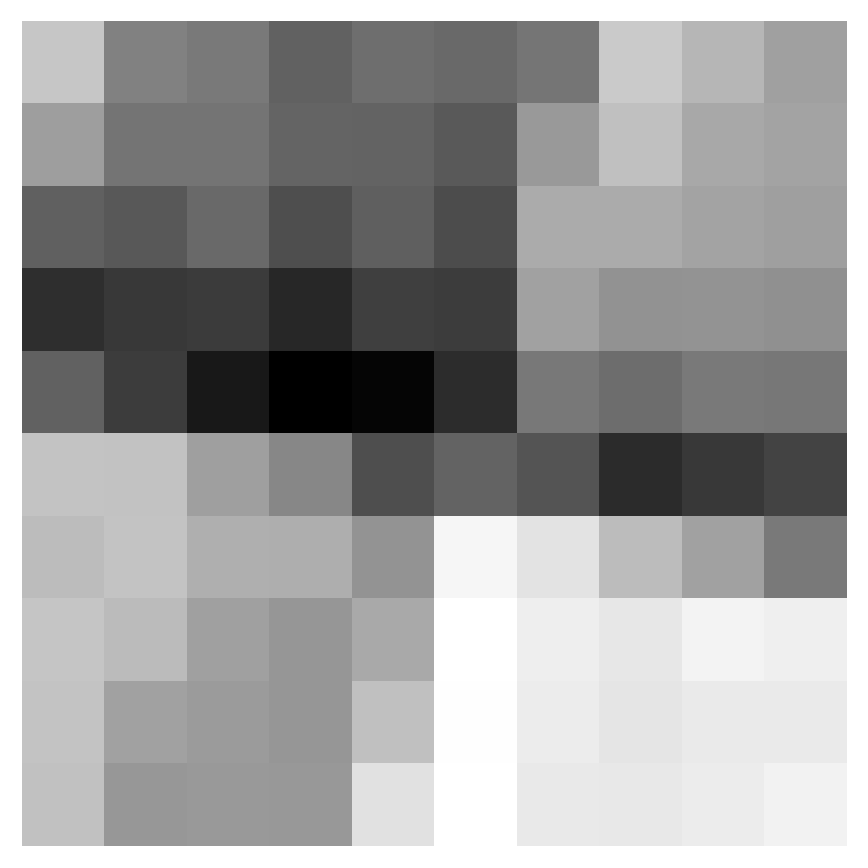

In [6]:

sg.refImages, sg.refNoises = sg.createReferences(trainSet, 7)
sg.showMe(trainSet, 0)


## <font style="color:lightblue">Models</font>

### <font style="color:lightblue">Generator</font>

In [7]:


class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(2)

        #latentChannels = 7
        #self.noise2latent = nn.Sequential(
        #    nn.Linear(sg.TCfg.latentDim, self.sinoSize*latentChannels),
        #    nn.ReLU(),
        #    nn.Unflatten( 1, (latentChannels,) + self.sinoSh )
        #)

        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            sg.fillWheights(layers)
            return torch.nn.Sequential(*layers)
        self.encoders =  nn.ModuleList([
            encblock(  1,                baseChannels, 3, norm=False),
            encblock(  baseChannels,     baseChannels, 3),
            encblock(  baseChannels,     baseChannels, 3),
            ])

        smpl = torch.zeros((1,1,*self.sinoSh))
        for encoder in self.encoders :
            smpl = encoder(smpl)
        encSh = smpl.shape
        linChannels = math.prod(encSh)
        self.fcLink = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Linear(linChannels, linChannels),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, encSh[1:]),
        )
        sg.fillWheights(self.fcLink)

        def decblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.ConvTranspose2d(chIn, chOut, kernel, stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            sg.fillWheights(layers)
            return torch.nn.Sequential(*layers)
        self.decoders = nn.ModuleList([
            decblock(2*baseChannels, baseChannels, 3),
            decblock(2*baseChannels, baseChannels, 3),
            decblock(2*baseChannels, baseChannels, 3, norm=False),
            ])

        self.lastTouch = nn.Sequential(
            nn.Conv2d(baseChannels+1, 1, 1),
            nn.Tanh(),
        )
        sg.fillWheights(self.lastTouch)


    def forward(self, input):

        images, _ = input
        images, orgDims = sg.unsqeeze4dim(images)
        modelIn = images.clone()
        modelIn[self.gapRng] = self.preProc(images)

        minv = modelIn.min(dim=-1).values.min(dim=-1).values
        ampl = modelIn.max(dim=-1).values.max(dim=-1).values - minv
        minv = minv[:,:,None,None]
        ampl = ampl[:,:,None,None]
        iampl = torch.where(ampl==0, 0, 2/ampl)
        modelIn = ( modelIn - minv ) * iampl - 1 # stretch

        #latent = self.noise2latent(noises)
        #modelIn = torch.cat((modelIn,latent),dim=1).to(sg.TCfg.device)
        dwTrain = [modelIn,]
        for encoder in self.encoders :
            dwTrain.append(encoder(dwTrain[-1]))
        mid = self.fcLink(dwTrain[-1])
        upTrain = [mid]
        for level, decoder in enumerate(self.decoders) :
            upTrain.append( decoder( torch.cat( (upTrain[-1], dwTrain[-1-level]), dim=1 ) ) )
        res = self.lastTouch(torch.cat( (upTrain[-1], modelIn), dim=1 ))

        patches = ( 2*res[self.gapRng] + modelIn[:,[0],:, self.gapRngX] + 1 ) * ampl / 2 + minv #destretch
        return sg.squeezeOrg(patches, orgDims)


sg.generator = Generator()
sg.generator.to(sg.TCfg.device)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )




Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 10, 2]             --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             640
│    │    └─LeakyReLU: 3-2               [1, 64, 8, 8]             --
│    └─Sequential: 2-2                   [1, 64, 6, 6]             --
│    │    └─Conv2d: 3-3                  [1, 64, 6, 6]             36,928
│    │    └─BatchNorm2d: 3-4             [1, 64, 6, 6]             128
│    │    └─LeakyReLU: 3-5               [1, 64, 6, 6]             --
│    └─Sequential: 2-3                   [1, 64, 4, 4]             --
│    │    └─Conv2d: 3-6                  [1, 64, 4, 4]             36,928
│    │    └─BatchNorm2d: 3-7             [1, 64, 4, 4]             128
│    │    └─LeakyReLU: 3-8               [1, 64, 4, 4]             --
├─Se

### <font style="color:lightblue">Discriminator</font>

In [8]:

class Discriminator(sg.DiscriminatorTemplate):

    def __init__(self):
        super(Discriminator, self).__init__()
        baseChannels = 64

        def encblock(chIn, chOut, kernel, stride=1, norm=True) :
            layers = []
            layers.append(nn.Conv2d(chIn, chOut, kernel, stride=stride, bias=True))
            if norm :
                layers.append(nn.BatchNorm2d(chOut))
            layers.append(nn.LeakyReLU(0.2))
            return torch.nn.Sequential(*layers)
        self.body = nn.Sequential(
            encblock(1,            baseChannels, 3, norm=False),
            encblock(baseChannels, baseChannels, 3),
            encblock(baseChannels, baseChannels, 3),
        )
        sg.fillWheights(self.body)

        encSh = self.body(torch.zeros((1,1,*sg.DCfg.sinoSh))).shape
        linChannels = math.prod(encSh)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(linChannels, baseChannels*2),
            nn.LeakyReLU(0.2),
            nn.Linear(baseChannels*2, 1),
            nn.Sigmoid()
        )
        sg.fillWheights(self.head)

    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)



### <font style="color:lightblue">Optimizers</font>

In [9]:
sg.optimizer_G , sg.optimizer_D = sg.createOptimizers()

## <font style="color:lightblue">Restore checkpoint</font>

/home/imbl/usr/src/sinogap/sinogap_module.py:274: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkPoint = torch.load(path, map_location=TCfg.device)


Probabilities of reference images: Ref: 0.000e+00, Gen: 0.000e+00, Pre: 0.000e+00.
Distances of reference images: REC: 1.578e-02, MSE: 1.578e-02, L1L: 8.067e-02.


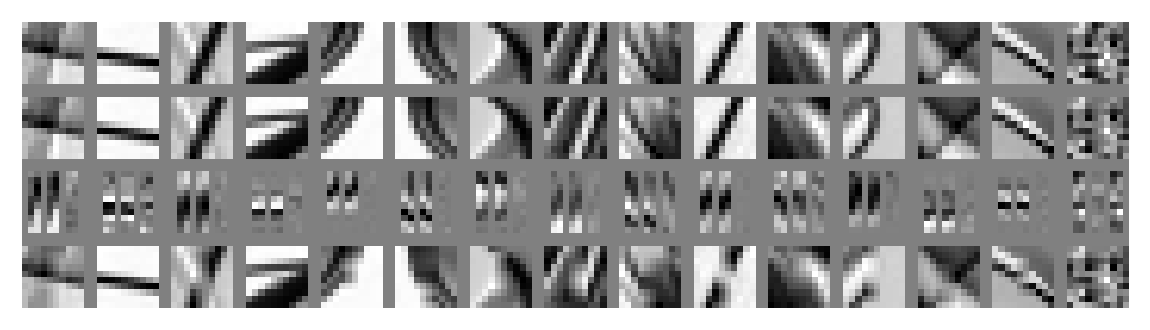

In [10]:
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.iter, sg.minGEpoch, sg.minGdLoss = sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.epoch, sg.iter = 0 , 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)
sg.initialTest()

## <font style="color:lightblue">Execute</font>

Epoch: 3662 (2934). Losses:  Dis: 0.000 (0.000), Gen: 0.000 (0.000), Rec: 6.546e-05 (6.518e-05 / 6.114e-04).
TT: 1.0158e-04 (1221772,836),  FT: 1.7920e-06 (1597631,617),  HD: 9.565e-02 (3904286,2106),  GP: 0.00000, 0.00000 
TF: 6.5289e-06 (105999,948),  FF: 2.2123e-05 (1429733,583),  LD: 7.725e-09 (1508286,851),  R : 0.00000.


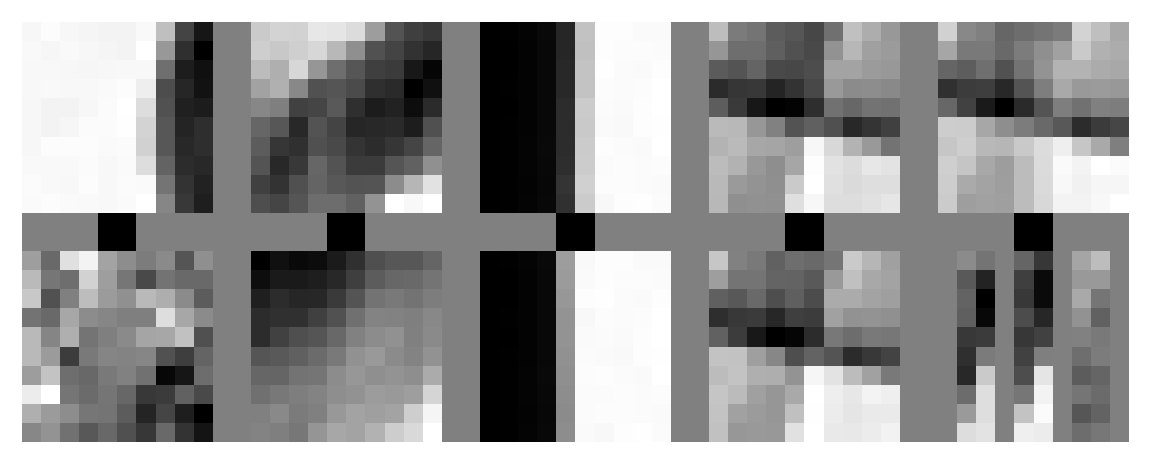

 10%|█         | 4/40 [00:46<07:00, 11.68s/it]


In [ ]:

#for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
#    item['lr'] *= 0.1
sg.dataLoader = sg.createTrainLoader(trainSet, num_workers=24)

#torch.autograd.set_detect_anomaly(True)
#Summary. Rec: 6.114e-04, MSE: 6.114e-04, L1L: 9.813e-03.
sg.prepGdLoss = 6.114e-04
if sg.prepGdLoss == 0:
    Rec_diff, MSE_diff, L1L_diff = sg.summarizeSet(sg.dataLoader)
    sg.prepGdLoss = Rec_diff
    sg.writer.add_scalars("Distances per epoch",
                          {'MSE0': MSE_diff
                          ,'L1L0': L1L_diff
                          ,'REC0': Rec_diff
                          }, 0 )


lrReduction=1.0
def my_afterEachEpoch(epoch) :
    global lrReduction
    if sg.minGEpoch < 2300  and epoch < 2500:
        return
    lrReduction *= 0.99
    for item in itertools.chain( sg.optimizer_D.param_groups, sg.optimizer_G.param_groups ):
        item['lr'] *= 0.99
    print("LR: ",lrReduction)
sg.afterEachEpoch = my_afterEachEpoch

try :
    sg.train(savedCheckPoint)
except :
    del sg.dataLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    raise

# stretch-add,  wide, links, Diff, 3Layers, eval/train, nograd, double patches, double FC,
# last-in, pure MSE, batch=4096

## <font style="color:lightblue">Post</font>

In [ ]:
sg.testMe(trainSet, 2)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()